# Plot Data on a Map

### Work in progress notebook

First thing to do is to makes sure that the required packages are imported:

In [18]:
# Import the required packages:

import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Next up is to select the dataset which contain the data that is to be plotted:

In [19]:
# Open a dataset using the OPENDAP-url

ds = xr.open_dataset('https://thredds.met.no/thredds/dodsC/remotesensingenvisat/asar-doppler/2012/01/27/ASA_WSDV2PRNMI20120127_215005_000612433111_00101_51839_0000.nc')
ds

<xarray.Dataset> Size: 45MB
Dimensions:                   (y: 602, x: 851)
Dimensions without coordinates: y, x
Data variables: (12/22)
    sensor_view_angle         (y, x) float32 2MB ...
    sigma0                    (y, x) float32 2MB ...
    subswaths                 (y, x) float32 2MB ...
    incidence_angle           (y, x) float32 2MB ...
    sensor_azimuth            (y, x) float32 2MB ...
    dc                        (y, x) float32 2MB ...
    ...                        ...
    wind_speed                (y, x) float32 2MB ...
    geophysical_doppler       (y, x) float32 2MB ...
    ground_range_current      (y, x) float32 2MB ...
    std_ground_range_current  (y, x) float32 2MB ...
    longitude                 (y, x) float32 2MB ...
    latitude                  (y, x) float32 2MB ...
Attributes: (12/75)
    GDAL:                       GDAL 3.2.1, released 2020/12/29
    acknowledgement:            GSAR IDL pre-processing software was develope...
    azimuth_start_time:         2012-01-27T21:50:05.173597
    contributor_email:          jeong-won.park@kopri.re.kr, hjoh@norceresearc...
    contributor_institution:    Korea Polar Research Institute (KOPRI), NORCE...
    contributor_name:           Jeong-Won Park, Harald Johnsen, Geir Engen, M...
    ...                         ...
    ysamplefreq_slc:            1711.9144385026736
    ysize:                      629
    ytime:                      2012-01-27T21:50:05.173597Z
    ytime_slc:                  2012-01-27T21:50:04.077748
    summary_no:                 Kalibrert geofysisk Dopplerskift fra ENVISAT ...
    title_no:                   Kalibrert geofysisk ENVISAT ASAR Dopplerskift...

This enables the possibility to easily plot the desired variables contained within the dataset.

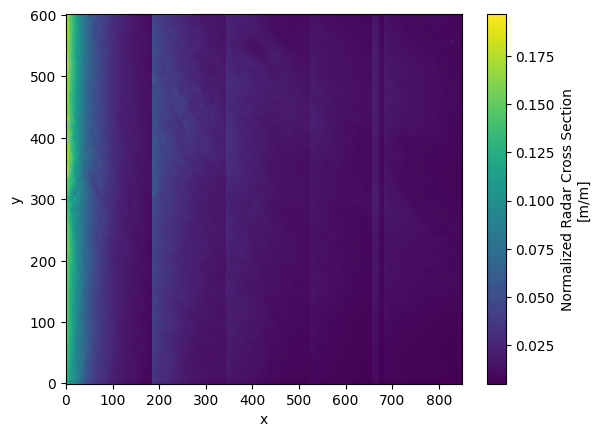

In [20]:
# Plotting a selected variable from the dataset opened above:

ds.sigma0.plot()
plt.show()

Below is a code snippet which easily extracts the wanted files from "Downloads" (given a recognicable part of the filenames) meant for extracting files which have been downloaded. This can be used when files have been dowloaded from i.e. [data.met.no](https://data.met.no/metsis/search), see the [Visualize Data with WMS](visualize:data:WMS) section ont the [Sar Dataset Accessibility](accessibility:page) page.

In [21]:
# how to open data when downloaded from the staging page: https://data-staging.met.no/metsis/elements/no-met-staging-e19b9c36-a9dc-4e13-8827-c998b9045b54/search

# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Use os.path.join to combine paths
path2files = os.path.join(home_dir, "Downloads") # "Dowloads" --> path to files

# Specify something to recognice the desired nc-files, extract them and put them in a list
desired_files_paths = glob.glob(os.path.join(path2files, "ASA_*.nc"))
# print(desired_files_paths)


# Open the first dataset
ds = xr.open_dataset(desired_files_paths[0])
# print(desired_files_paths[0])

# Interactive overview of the dataset
ds

<xarray.Dataset> Size: 45MB
Dimensions:                   (y: 602, x: 851)
Dimensions without coordinates: y, x
Data variables: (12/22)
    sensor_view_angle         (y, x) float32 2MB ...
    sigma0                    (y, x) float32 2MB ...
    subswaths                 (y, x) float32 2MB ...
    incidence_angle           (y, x) float32 2MB ...
    sensor_azimuth            (y, x) float32 2MB ...
    dc                        (y, x) float32 2MB ...
    ...                        ...
    wind_speed                (y, x) float32 2MB ...
    geophysical_doppler       (y, x) float32 2MB ...
    ground_range_current      (y, x) float32 2MB ...
    std_ground_range_current  (y, x) float32 2MB ...
    longitude                 (y, x) float32 2MB ...
    latitude                  (y, x) float32 2MB ...
Attributes: (12/75)
    GDAL:                       GDAL 3.2.1, released 2020/12/29
    acknowledgement:            GSAR IDL pre-processing software was develope...
    azimuth_start_time:         2012-01-27T21:50:05.173597
    contributor_email:          jeong-won.park@kopri.re.kr, hjoh@norceresearc...
    contributor_institution:    Korea Polar Research Institute (KOPRI), NORCE...
    contributor_name:           Jeong-Won Park, Harald Johnsen, Geir Engen, M...
    ...                         ...
    ysamplefreq_slc:            1711.9144385026736
    ysize:                      629
    ytime:                      2012-01-27T21:50:05.173597Z
    ytime_slc:                  2012-01-27T21:50:04.077748
    summary_no:                 Kalibrert geofysisk Dopplerskift fra ENVISAT ...
    title_no:                   Kalibrert geofysisk ENVISAT ASAR Dopplerskift...

## Plotting Function

Below is an easy to use plotting function which visualize your desired data variable on a map. There is also possible to set the spatial extent of the plot yourself - default is just plotting the spatial extent of the variable itself as defined in the metadata.

In [22]:
def plotting_variables_on_a_map(variable, number_of_colorbar_intervals = 100, 
                                lat_min = ds.geospatial_lat_min, lat_max = ds.geospatial_lat_max, 
                                lon_min = ds.geospatial_lon_min, lon_max = ds.geospatial_lon_max,
                                fractional_title_spacing = 0.05,
                                title_fontsize = 15,
                                cbar_label_fontsize = 12):

    # Create a linear space for latitude and longitude
    lat = np.linspace(ds.geospatial_lat_min, ds.geospatial_lat_max, ds.sizes['y'])
    lon = np.linspace(ds.geospatial_lon_min, ds.geospatial_lon_max, ds.sizes['x'])

    # Create a new xarray DataArray with latitude and longitude as coordinates
    variable_with_coords = xr.DataArray(variable.values, coords=[('lat', lat), ('lon', lon)], dims=['y', 'x'])

    # Assign variable attributes from the original variable DataArray
    variable_with_coords.attrs = variable.attrs

    # Now select your slice - defined by the latitudinal and longitudinal extent of the data
    plotable_variable = variable_with_coords.sel(x=slice(ds.geospatial_lon_min, ds.geospatial_lon_max), y=slice(ds.geospatial_lat_min, ds.geospatial_lat_max))

    # Ready to plot the variable on a map using subplot package of matplotlib.pyplot
    # Create the main plot and set the projection
    fig, ax = plt.subplots(1, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.axis('off')   # Turn off axes
    ax.coastlines()  # Add coastlines

    # Create the gridlines and configure the labels
    gl = ax.gridlines(draw_labels=True)
    gl.bottom_labels = True   # Default
    gl.left_labels = True     # Default
    gl.top_labels = True      # Default
    gl.right_labels = False   # Not default

    # Defining var_min, var_max and var_step --- using the variable attribute minmax to extract var_min and var_max
    var_min = int(plotable_variable.minmax.split(' ')[0])
    var_max = int(plotable_variable.minmax.split(' ')[1])
    
    var_step = ((var_max - var_min) / number_of_colorbar_intervals)

    var_max = int(plotable_variable.minmax.split(' ')[1]) + var_step   # redefining the max val to improve visuals of colorbar around center

    # Add features for land and ocean
    ax.add_feature(cfeature.LAND, facecolor='tan', zorder=2)     # Tan color for land - Placed third in line for plotting
    ax.add_feature(cfeature.OCEAN, facecolor='grey', zorder=0)    # Grey color for ocean - Placed first in line for plotting
    
    # Plot the data
    cax = plotable_variable.plot.contourf(ax=ax, x='x', y='y',
                        extend='neither',
                        norm=TwoSlopeNorm(vmin=var_min, vcenter=0, vmax=var_max),
                        levels=np.arange(var_min, var_max, var_step),
                        add_colorbar=False,  # Do not automatically add colorbar
                        zorder = 1
                        )

    # Create an inset axes for the colorbar
    cbar_ax = inset_axes(ax,
                        width="5%",  # width = 5% of parent_bbox width
                        height="100%",  # height : 100% of parent_bbox height
                        loc='lower left',
                        bbox_to_anchor=(1.05, 0., 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0
                        )

    # Create colorbar
    cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f'[{plotable_variable.units}]', fontsize = cbar_label_fontsize)  # Extract units from the plotted variable and use as label for colorbar

    # Set and adjust title
    mid_lat = (lat_min + lat_max) / 2
    mid_lon = (lon_min + lon_max) / 2
    ax.text(mid_lon, lat_max + ((lat_max - lat_min) * fractional_title_spacing), f'{plotable_variable.long_name}',
            fontsize=title_fontsize, ha='center')

    # Setting the extent on the map that is plotted
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlim(lon_min, lon_max)

    plt.show()

    return

## Plotting Examples

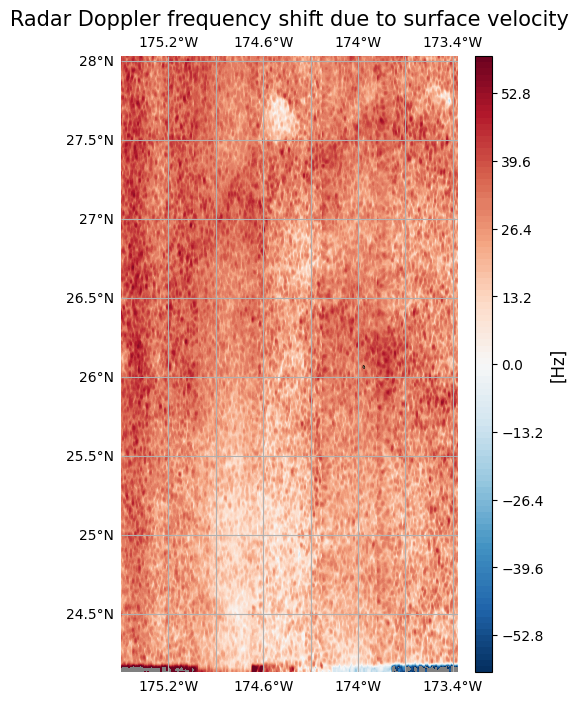

In [23]:
# Plotting the desired variable within its geographical extent - By default using the metadata for the geographical extent as lat/lon min/max values.


# Plotting geophysical_doppler - new name
plotting_variables_on_a_map(variable = ds.geophysical_doppler,
                            number_of_colorbar_intervals = 100,  # Default value
                            title_fontsize = 15,                 # Default value
                            cbar_label_fontsize = 12             # Default value
                            )

Alter the spatial extent of the maqp at which the selected variable is plotted on:

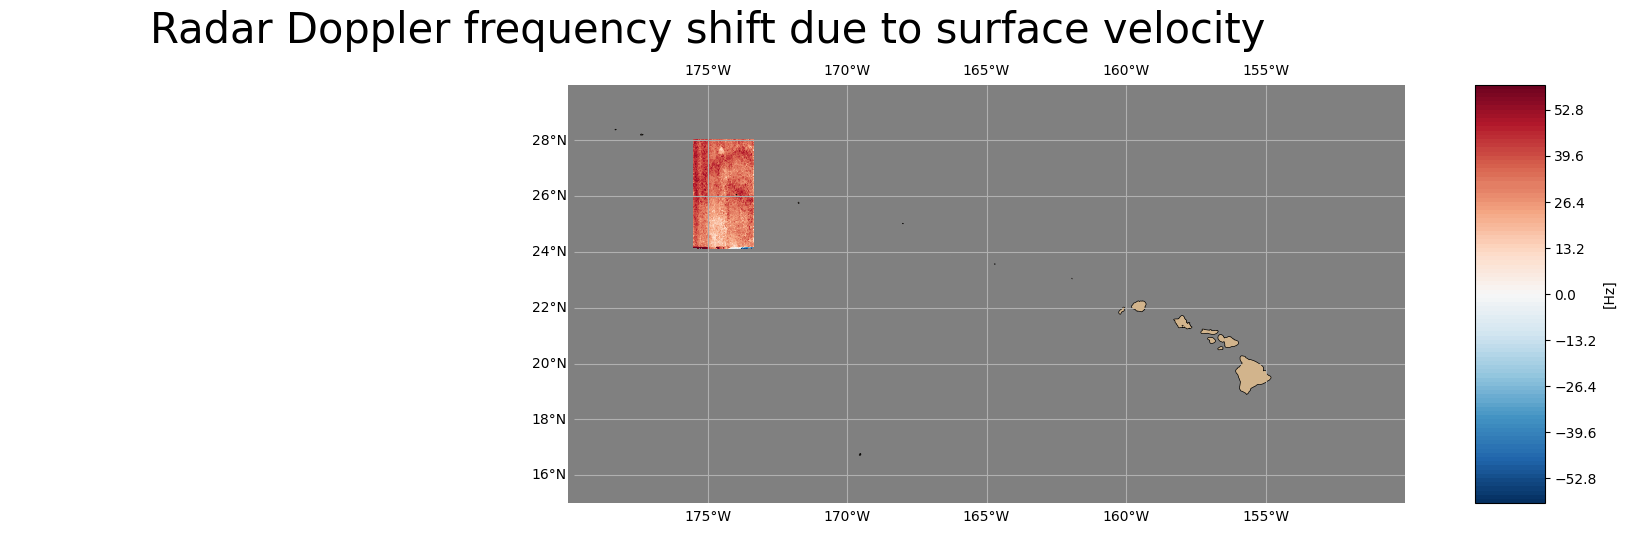

In [24]:
# Plotting geophysical_doppler
plotting_variables_on_a_map(variable = ds.geophysical_doppler, 
                            lat_min = 15, lat_max = 30,
                            lon_min = -200, lon_max = -150,
                             number_of_colorbar_intervals = 100, # Default value
                            fractional_title_spacing = 0.10,     # Default 0.05
                            title_fontsize = 30,                 # Default value
                            cbar_label_fontsize = 10             # Default 12
                            )

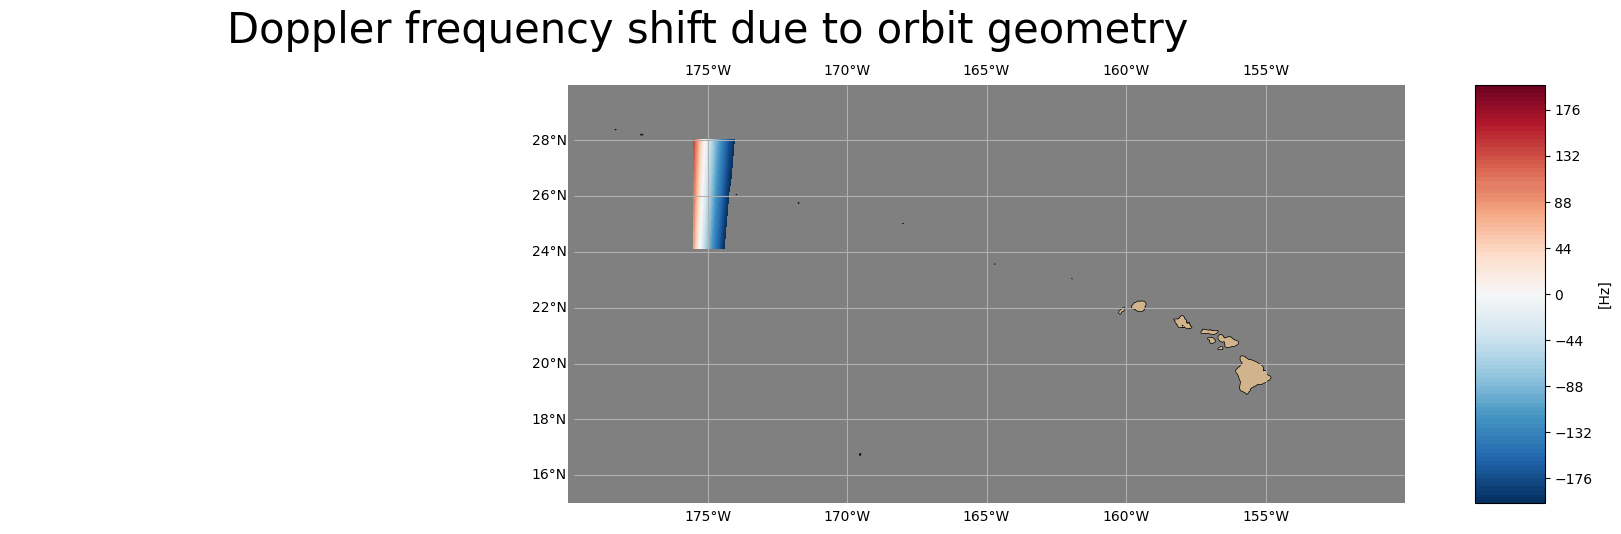

In [25]:
# Plotting geometric_doppler 
plotting_variables_on_a_map(variable = ds.geometric_doppler, 
                            # lat_min = 20, lat_max = 50,
                            # lon_min = -85, lon_max = -65 
                            lat_min = 15, lat_max = 30,
                            lon_min = -200, lon_max = -150,
                            number_of_colorbar_intervals = 100,  # Default value
                            fractional_title_spacing = 0.10,     # Default 0.05
                            title_fontsize = 30,                 # Default value
                            cbar_label_fontsize = 10             # Default 12
                            )

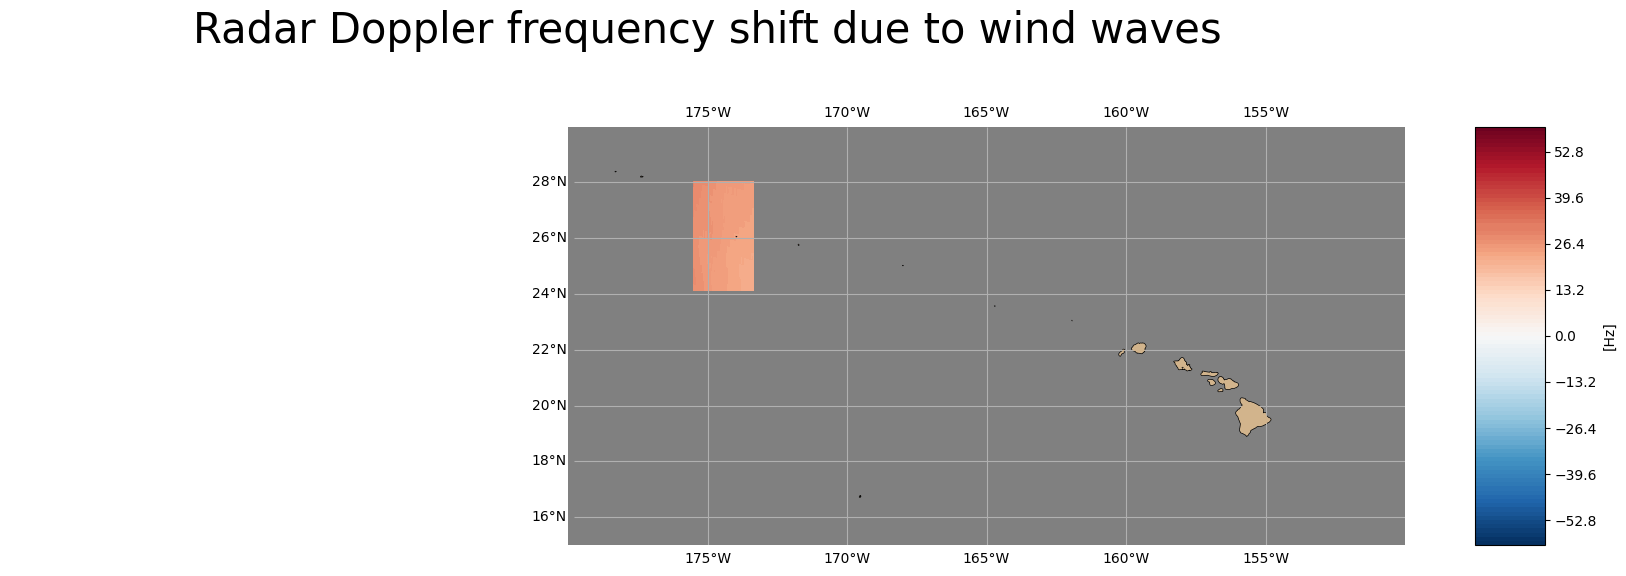

In [26]:
# Plotting wind_waves_doppler
plotting_variables_on_a_map(variable = ds.wind_waves_doppler,
                            lat_min = 15, lat_max = 30,
                            lon_min = -200, lon_max = -150,
                             number_of_colorbar_intervals = 100, # Default value
                            fractional_title_spacing = 0.20,     # Default 0.05
                            title_fontsize = 30,                 # Default value
                            cbar_label_fontsize = 10             # Default 12
                            )


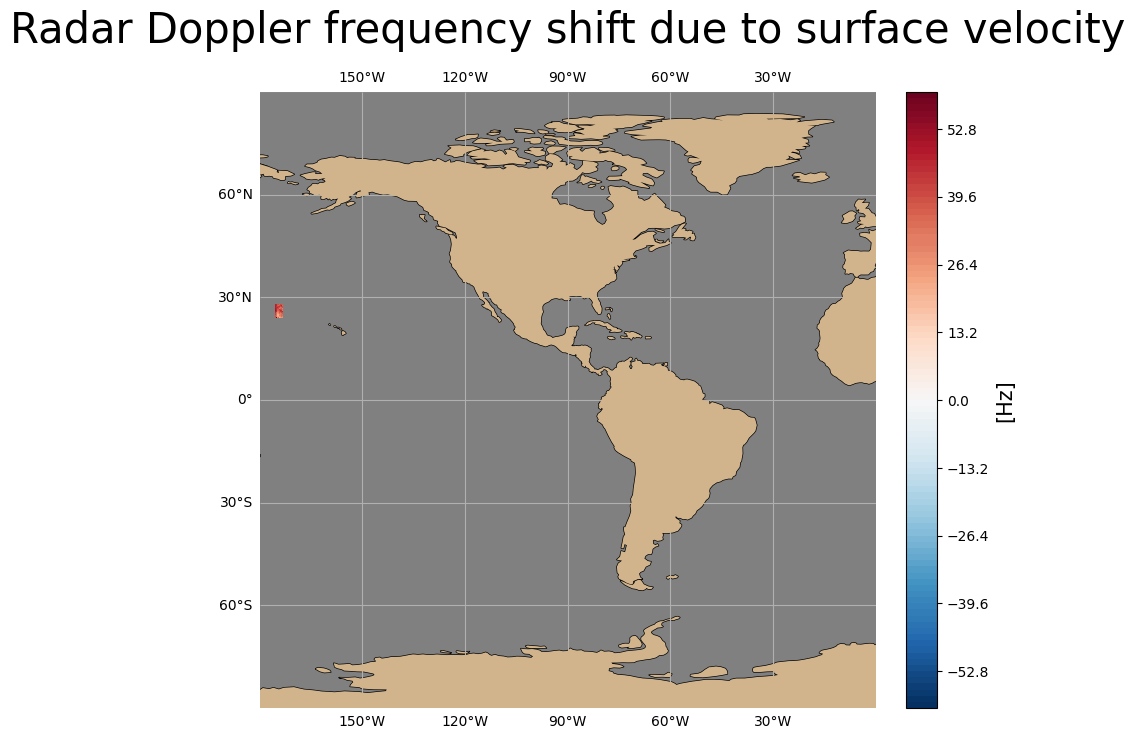

In [27]:
# Plotting geophysical_doppler
plotting_variables_on_a_map(variable = ds.geophysical_doppler, 
                            lat_min = -90, lat_max = 90,
                            lon_min = -180, lon_max = 0, 
                            number_of_colorbar_intervals = 100,  # Default value
                            fractional_title_spacing = 0.08,     # Default 0.05
                            title_fontsize = 30,                 # Default 15
                            cbar_label_fontsize = 15             # Default 12
                            )

## Plotting with a Polar Projection

As the SAR Doppler data is a great asset when researching areas at high latitudes, there is also provided an example function below which extracts and plots desired variables on a map with an Arctic projection.

In [28]:
def ArcticPlot_variables_on_a_map(dataset, 
                                variable,
                                map_color,
                                map_start_longitude = -180,
                                map_end_longitude = 180,
                                map_edge_latitude = 60,
                                map_center_latitude = 90,
                                fractional_title_spacing = 0.05,
                                title_fontsize = 15,
                                log_scale_option = False):

    # Create a linear space for latitude and longitude
    lat = np.linspace(dataset.geospatial_lat_min, dataset.geospatial_lat_max, dataset.sizes['y'])
    lon = np.linspace(dataset.geospatial_lon_min, dataset.geospatial_lon_max, dataset.sizes['x'])

    # Create a new xarray DataArray with latitude and longitude as coordinates
    if log_scale_option == True:
        variable_with_coords = xr.DataArray(np.log10(variable.values)*10, coords=[('lat', lat), ('lon', lon)], dims=['y', 'x'])   # converting the linear backscatter values to dB (decibel) [Source: https://dspillustrations.com/pages/posts/misc/decibel-conversion-factor-10-or-factor-20.html]
    else:
        variable_with_coords = xr.DataArray(variable.values, coords=[('lat', lat), ('lon', lon)], dims=['y', 'x'])

    # Assign variable attributes from the original variable DataArray
    variable_with_coords.attrs = variable.attrs

    # Now select your slice - defined by the latitudinal and longitudinal extent of the data
    plotable_variable = variable_with_coords.sel(x=slice(dataset.geospatial_lon_min, dataset.geospatial_lon_max), y=slice(dataset.geospatial_lat_min, dataset.geospatial_lat_max))

    fig, ax = plt.subplots(1, figsize=(10, 6))
    fig.suptitle(f'{variable.long_name}', fontsize = title_fontsize)
    ax.axis('off')   # These do no longer make sense and are just a nuisance

    # Set the projection
    ax = plt.axes(projection=ccrs.NorthPolarStereo())   # Selecting a projection with the North Pole in its center.
    ax.coastlines()                                            # Adding coastlines
    ax.set_extent([map_start_longitude, map_end_longitude, map_edge_latitude, map_center_latitude], crs=ccrs.PlateCarree()) # Lower Boundry of 65 deg North to just evaluate the Arctic.

    # Add features for land and ocean
    ax.add_feature(cfeature.LAND, facecolor='tan', zorder=2)     # Tan color for land - Placed third in line for plotting
    ax.add_feature(cfeature.OCEAN, facecolor='grey', zorder=0)    # Grey color for ocean - Placed first in line for plotting

    
    if log_scale_option == True:
        plotable_variable.plot.pcolormesh(ax=ax, x='x', y='y',
                            transform=ccrs.PlateCarree(),  # added transform argument
                            extend='neither',
                            # levels=np.arange(var_min, var_max, var_step),      
                            cbar_kwargs = {'label': 'Decibel [dB]'},
                            # cmap='Blues_r',                                               # "_r" --> inverse of the selected cmap
                            # cmap='gray',
                            cmap=map_color,
                            zorder = 1                                                    # Placed second in line for plotting
                            )
    else:
        plotable_variable.plot.pcolormesh(ax=ax, x='x', y='y',
                            transform=ccrs.PlateCarree(),  # added transform argument
                            extend='neither',
                            # levels=np.arange(var_min, var_max, var_step),
                            cbar_kwargs = {'label': f'[{variable.units}]'},      
                            # cmap='Blues_r',                                               # "_r" --> inverse of the selected cmap
                            # cmap='gray',
                            cmap=map_color,
                            zorder = 1                                                    # Placed second in line for plotting
                            )


    
    gl = ax.gridlines(draw_labels=True)

    plt.tight_layout()
    plt.show()

    return

By getting hold of a dataset of variables to plot, the plotting could be done as follows:

In [29]:
# Downloaded
# ds_arctic = xr.open_dataset('ASA_WSDH2PRNMI20120322_111545_000623843113_00023_52623_0000.nc')  # Downloaded

# OPENDAP
ds_arctic = xr.open_dataset('https://thredds.met.no/thredds/dodsC/remotesensingenvisat/asar-doppler/2012/03/22/ASA_WSDH2PRNMI20120322_111545_000623843113_00023_52623_0000.nc')  # OPeNDAP
ds_arctic

<xarray.Dataset> Size: 46MB
Dimensions:                   (y: 611, x: 847)
Dimensions without coordinates: y, x
Data variables: (12/22)
    sensor_view_angle         (y, x) float32 2MB ...
    sigma0                    (y, x) float32 2MB ...
    subswaths                 (y, x) float32 2MB ...
    incidence_angle           (y, x) float32 2MB ...
    sensor_azimuth            (y, x) float32 2MB ...
    dc                        (y, x) float32 2MB ...
    ...                        ...
    wind_speed                (y, x) float32 2MB ...
    geophysical_doppler       (y, x) float32 2MB ...
    ground_range_current      (y, x) float32 2MB ...
    std_ground_range_current  (y, x) float32 2MB ...
    longitude                 (y, x) float32 2MB ...
    latitude                  (y, x) float32 2MB ...
Attributes: (12/75)
    GDAL:                       GDAL 3.2.1, released 2020/12/29
    acknowledgement:            GSAR IDL pre-processing software was develope...
    azimuth_start_time:         2012-03-22T11:15:45.996631
    contributor_email:          jeong-won.park@kopri.re.kr, hjoh@norceresearc...
    contributor_institution:    Korea Polar Research Institute (KOPRI), NORCE...
    contributor_name:           Jeong-Won Park, Harald Johnsen, Geir Engen, M...
    ...                         ...
    ysamplefreq_slc:            1711.9144385026736
    ysize:                      640
    ytime:                      2012-03-22T11:15:45.996631Z
    ytime_slc:                  2012-03-22T11:15:44.997749
    summary_no:                 Kalibrert geofysisk Dopplerskift fra ENVISAT ...
    title_no:                   Kalibrert geofysisk ENVISAT ASAR Dopplerskift...

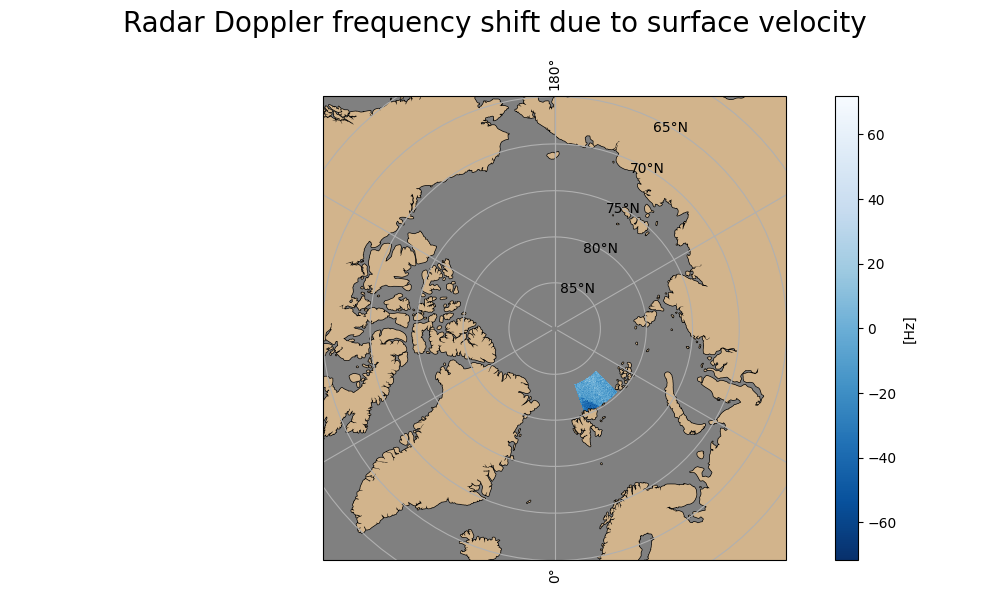

In [30]:
# The entire Arctic
ArcticPlot_variables_on_a_map(dataset = ds_arctic,
                            variable = ds_arctic.geophysical_doppler,
                            map_color = 'Blues_r',
                            map_start_longitude = -180,
                            map_end_longitude = 180,
                            map_edge_latitude = 65,    # Default 60
                            map_center_latitude = 90,  # Default 90
                            title_fontsize = 20        # Default 15
                            )

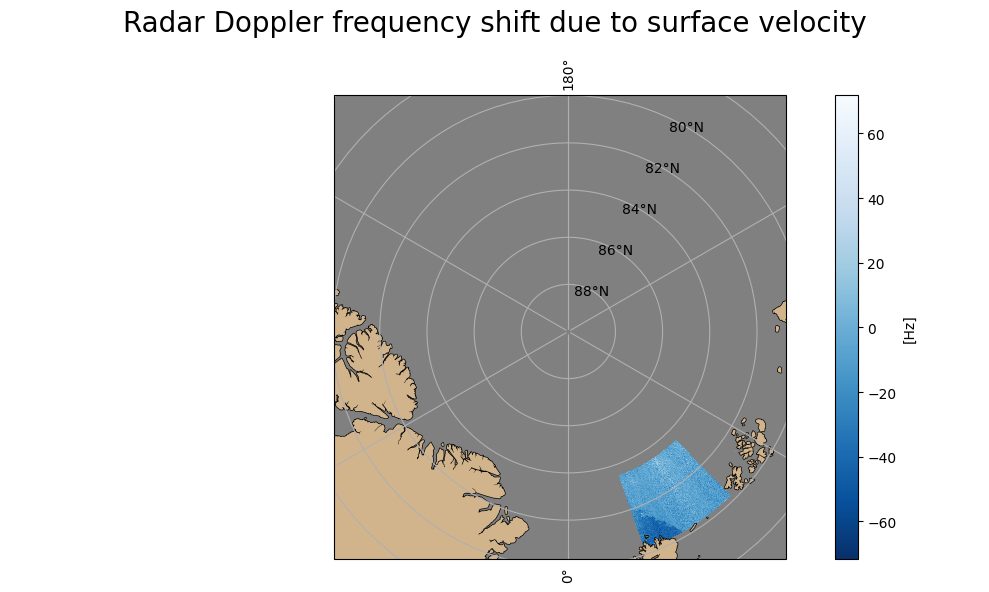

In [31]:
# Zooming in on the Arctic Ocean
ArcticPlot_variables_on_a_map(dataset = ds_arctic,
                            variable = ds_arctic.geophysical_doppler,
                            map_color = 'Blues_r',
                            map_start_longitude = -180,
                            map_end_longitude = 180,
                            map_edge_latitude = 80,    # Default 60
                            map_center_latitude = 90,  # Default 90
                            title_fontsize = 20        # Default 15
                            )

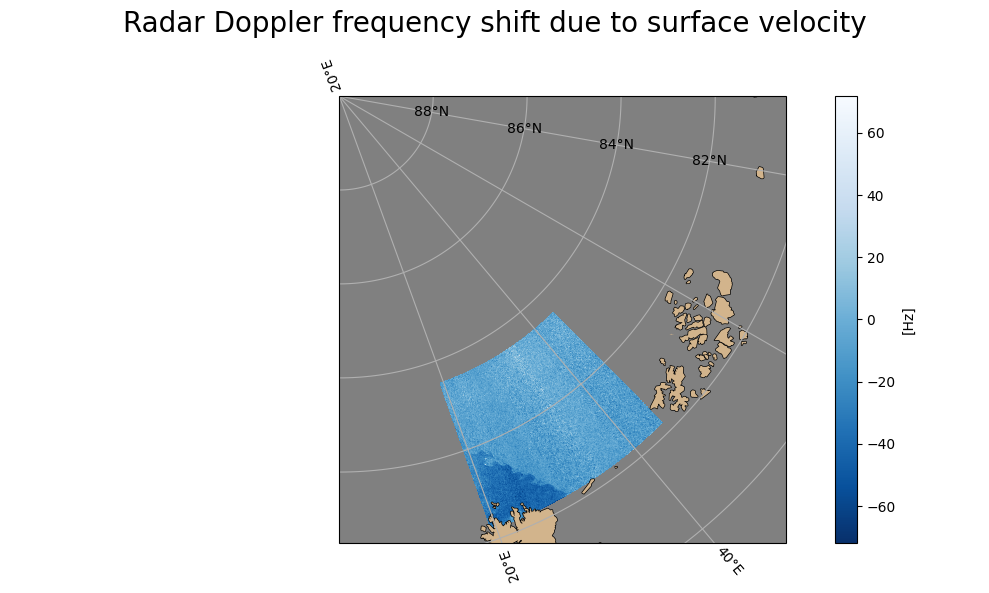

In [32]:
# A quarter of the sphere covering the Arctic Ocean
ArcticPlot_variables_on_a_map(dataset = ds_arctic,
                            variable = ds_arctic.geophysical_doppler,
                            map_color = 'Blues_r',
                            map_start_longitude = 0,
                            map_end_longitude = 90,    
                            map_center_latitude = 90,  # Default 90
                            map_edge_latitude = 80.5,  # Default 60
                            title_fontsize = 20        # Default 15
                            )

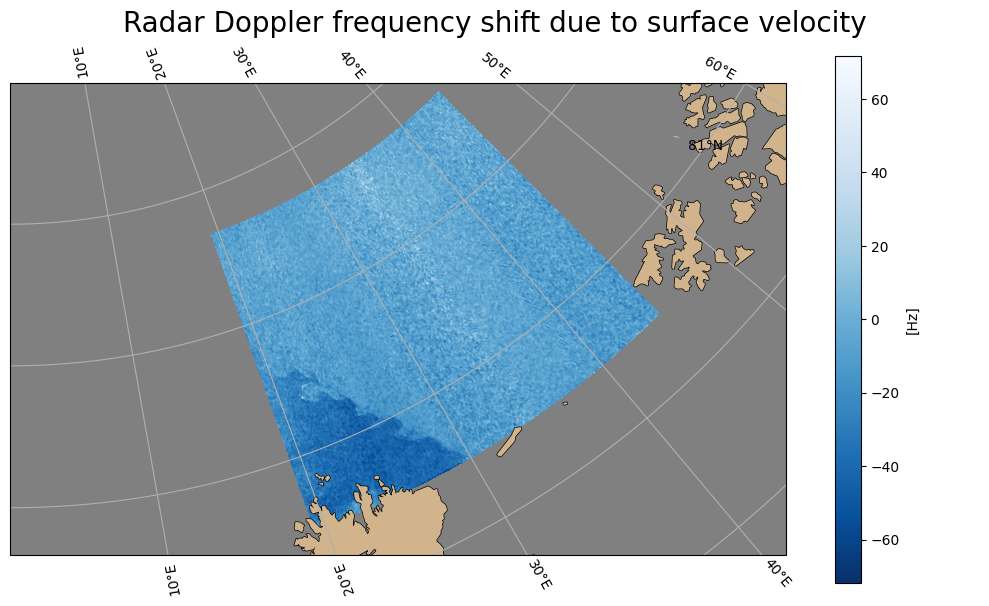

In [33]:
# Zooming into the geographic extent of the plotted variable
ArcticPlot_variables_on_a_map(dataset = ds_arctic,
                            variable = ds_arctic.geophysical_doppler,
                            map_color = 'Blues_r',
                            map_start_longitude = 0,
                            map_end_longitude = 60,    
                            map_center_latitude = 81,  # Default 90
                            map_edge_latitude = 80.5,    # Default 60
                            title_fontsize = 20        # Default 15
                            )

As an additional option, the plot below show that the selected variable, in this instance backscatter (sigma0), is attainable to plot on a log scale [dB] through setting the log_scale_option as True.

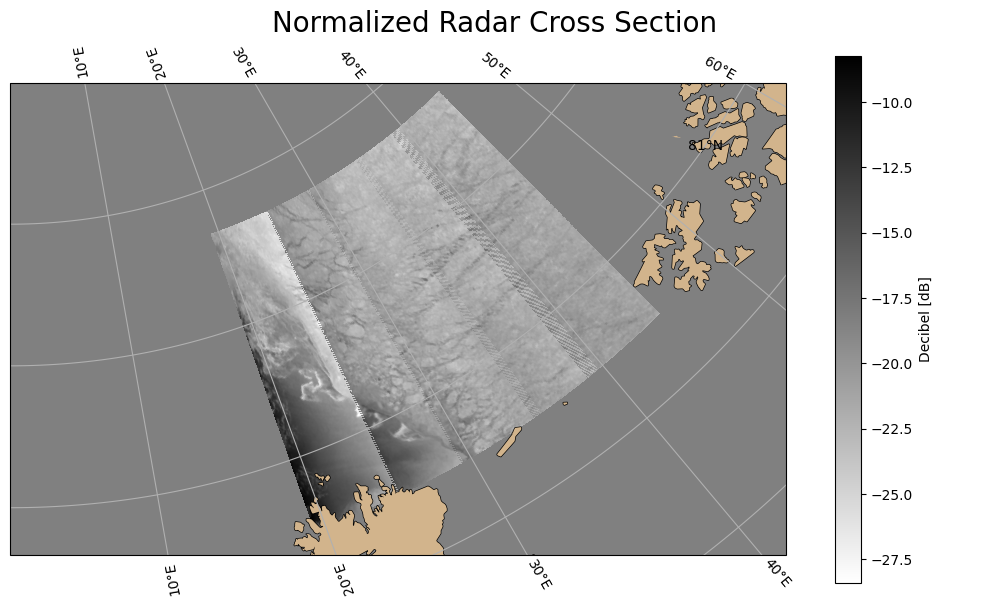

In [34]:
ArcticPlot_variables_on_a_map(dataset = ds_arctic,
                            variable = ds_arctic.sigma0,
                            map_color = 'gray_r',
                            map_start_longitude = 0,
                            map_end_longitude = 60,    
                            map_center_latitude = 81,  # Default 90
                            map_edge_latitude = 80.5,  # Default 60
                            title_fontsize = 20,       # Default 15
                            log_scale_option = True 
                            )